*CheXpert* : Defer experiments

Exp 1) Fake Toy Expert: sample complexity




# Imports and Data Prep

Get Dataset images

In [ ]:
# outdated data method

from google.colab import auth
auth.authenticate_user()
project_id = 'learning-to-defer'
!gcloud config set project {project_id}
!gsutil ls
!gsutil -m cp -r gs://chexpert_medium/CheXpert-v1.0-small.zip . 
!unzip -q CheXpert-v1.0-small.zip
# delete zip file
!rm CheXpert-v1.0-small.zip


KeyboardInterrupt: ignored

Get CheXpert data and dataset of expert data on test set and models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/My Drive/chexpert data/CheXpert-v1.0-small.zip" .


In [ ]:
!unzip -q CheXpert-v1.0-small.zip
# delete zip file
!rm CheXpert-v1.0-small.zip

In [ ]:
!cp -r "/content/drive/My Drive/chexpert test rad" .

In [ ]:
!cp -r "/content/drive/My Drive/model files deferal/chexpert" .

In [ ]:
import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import copy
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as func
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.ranking import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import random
import scipy.stats as st
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
use_gpu = torch.cuda.is_available()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Expert model
First read through radiologist files then build expert model to take in label and spit out a probability getting the prediction correctly. 

"
1, 2, 3, 5, 7 were the radiologists which constituted the ground truth.

4, 6, 8 were the radiologists we evaluated.
"

In [ ]:
class CheXpert_rad(Dataset):
    def __init__(self, file_path):
        """
        rad_files: list of all radiologist file path on the test set 
        """
        rad_files = []
        for i in range(8):
            s = file_path[:-5]+str(i+1)+".csv"
            s = str(s)
            rad_files.append(s)
        labels = []
        rads = [[] for _ in range(len(rad_files))] #store first predictions of all radiologists
        for idx in range(len(rad_files)):
            with open(rad_files[idx], "r") as f:
                csvReader = csv.reader(f)
                next(csvReader, None)
                k=0
                for line in csvReader:
                    k+=1
                    rad = line[1:15]
                    # need to switch because train and test are incosistent
                    temp = copy.deepcopy(rad[3])
                    rad[3] = rad[4]
                    rad[4] = temp
                    for i in range(14):
                        if rad[i]:
                            a = float(rad[i])
                            if a == 1:
                                rad[i] = 1
                            elif a == 0:
                                rad[i] = 0
                        else:
                            rad[i] = 0
                    rads[idx].append(rad)

        # in their paper: 0,1,2,4 and 6 define the label while 3,5,7 are the baseline
        for idx in range(len(rads[0])):
            label_all = []
            for i in range(14):
                preds = [rads[0][idx][i], rads[1][idx][i], rads[2][idx][i], rads[4][idx][i], rads[6][idx][i]]
                label = Counter(preds).most_common()[0][0] # get majority prediction
                label_all.append(label)
            labels.append(label_all)
        self.rad_1 = rads[3]
        self.rad_2 = rads[5]
        self.rad_3 = rads[7]
        self.labels = labels


    def __getitem__(self, index):
        """Take the index of item and returns the label and radioligist predictions"""
        label = self.labels[index]
        rad1 = self.rad_1[index]
        rad2 = self.rad_2[index]
        rad3 = self.rad_3[index]
        return torch.FloatTensor(label), torch.FloatTensor(rad1), torch.FloatTensor(rad2), torch.FloatTensor(rad3), 

    def __len__(self):
        return len(self.labels)

In [ ]:
class CheXpert_rad_eval(Dataset):
    def __init__(self, file_path, rad_index = None):
        """
        rad_files: list of all radiologist file path on the test set 
        """
        rad_files = []
        for i in range(8):
            s = file_path[:-5]+str(i+1)+".csv"
            s = str(s)
            rad_files.append(s)
        labels = []
        rads = [[] for _ in range(len(rad_files))] #store first predictions of all radiologists
        for idx in range(len(rad_files)):
            with open(rad_files[idx], "r") as f:
                csvReader = csv.reader(f)
                next(csvReader, None)
                k=0
                for line in csvReader:
                    k+=1
                    rad = line[1:15]
                    # need to switch because train and test are incosistent
                    temp = copy.deepcopy(rad[3])
                    rad[3] = rad[4]
                    rad[4] = temp
                    for i in range(14):
                        if rad[i]:
                            a = float(rad[i])
                            if a == 1:
                                rad[i] = 1
                            elif a == 0:
                                rad[i] = 0
                        else:
                            rad[i] = 0
                    rads[idx].append(rad)

        # in their paper: 0,1,2,4 and 6 define the label while 3,5,7 are the baseline
        for idx in range(len(rads[0])):
            label_all = []
            for i in range(14):
                if rad_index != None:
                    rad_indices = {0,1,2,3,4,5,6,7} - {rad_index}
                    set_rad = [rads[rad_idx][idx][i] for rad_idx in rad_indices]
                    label = Counter(set_rad).most_common()[0][0]
                    label_all.append(label)
                else:
                    preds = [rads[0][idx][i], rads[1][idx][i], rads[2][idx][i], rads[4][idx][i], rads[6][idx][i]]
                    label = Counter(preds).most_common()[0][0] # get majority prediction
                    label_all.append(label)
            labels.append(label_all)
        self.rad_1 = rads[0]
        self.rad_2 = rads[1]
        self.rad_3 = rads[2]
        self.rad_4 = rads[3]
        self.rad_5 = rads[4]
        self.rad_6 = rads[5]
        self.rad_7 = rads[6]
        self.rad_8 = rads[7]
        self.labels = labels


    def __getitem__(self, index):
        """Take the index of item and returns the label and radioligist predictions"""
        label = self.labels[index]
        rad1 = self.rad_1[index]
        rad2 = self.rad_2[index]
        rad3 = self.rad_3[index]
        rad4 = self.rad_4[index]
        rad5 = self.rad_5[index]
        rad6 = self.rad_6[index]
        rad7 = self.rad_7[index]
        rad8 = self.rad_8[index]

        return torch.FloatTensor(label), torch.FloatTensor(rad1), torch.FloatTensor(rad2), torch.FloatTensor(rad3), torch.FloatTensor(rad4), torch.FloatTensor(rad5), torch.FloatTensor(rad6), torch.FloatTensor(rad7), torch.FloatTensor(rad8),  

    def __len__(self):
        return len(self.labels)

In [ ]:
file_path = 'chexpert test rad/image_test_rad_1.csv'

expert_data = CheXpert_rad(file_path)
expertTest, expertTrain = random_split(expert_data, [100, len(expert_data) - 100]) # not used down the road
expertTestloader = DataLoader(dataset=expertTest, batch_size=1, shuffle=False)
expertTrainloader = DataLoader(dataset=expertTrain, batch_size=1, shuffle=False)
expert_loader = DataLoader(dataset=expert_data, batch_size=1, shuffle=False) # all_data

In [ ]:
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

Fake expert model:

If there is a supporting device, with probability p_nonconfound we are correct and if there is no support devices with probability p_confound we are correct.

In [ ]:
class ExpertModel_fake():
    def __init__(self, confounding_class, p_confound, p_nonconfound):
        self.confounding_class = confounding_class
        self.p_confound = p_confound
        self.p_nonconfound = p_nonconfound
    def predict(self, y):
        '''
        Using backoff
        y: list of targets where each is a python list of size 14
        returns: expert predictions for each of  expert 1
        '''
        preds = [[] for _ in range(3)]
        for rad_index in range(3):
            for i in range(len(y)):
                pred = [0] *14
                key_all = str(y[i])
                for cls in range(14):
                    if y[i][self.confounding_class] == 0:
                        if y[i][cls] == 1:
                            prediction = np.random.binomial(1,self.p_confound,1)[0]
                            pred[cls] = prediction
                        else:
                            prediction = np.random.binomial(1,1- self.p_confound,1)[0]
                            pred[cls] = prediction
                    else:
                        if y[i][cls] == 1:
                            prediction = np.random.binomial(1,self.p_nonconfound,1)[0]
                            pred[cls] = prediction
                        else:
                            prediction = np.random.binomial(1,1- self.p_nonconfound,1)[0]
                            pred[cls] = prediction       
                        #prediction = np.random.binomial(1,y[i][cls],1)[0]
                        #pred[cls] = prediction
                preds[rad_index].append(pred)
        return preds

In [ ]:
p_confound = 0.7 
p_nonconfound = 1.0
exp_fake = ExpertModel_fake(13,p_confound, p_nonconfound)

## Build Training and Valid set augmented with the expert predictions

In [ ]:
class CheXpertDataSet_rad(Dataset):
    def __init__(self, image_list_file, expert_model, patient_names,  transform=None, ignore_uncertain = True, policy="ones"):
        """
        image_list_file: path to the file containing images with corresponding labels.
        expert_model: instance of ExpertModel_1 trained
        patient_names: which patients to include in set, dictionary
        is_val: if using the validation set 
        transform: optional transform to be applied on a sample.
        Upolicy: name the policy with regard to the uncertain labels: ones by default
        """
        image_names = []
        labels = []
        rad_1 = []
        rad_2 = []
        rad_3 = []
        weights = [] # indicates if uncertainty label is present or not for each task
        with open(image_list_file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1

                image_name= line[0]
                patient_name = line[0].split("/")[2]
                label = line[5:]
                weight = [1] *14
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1: # uncertain label
                            if ignore_uncertain:
                                weight[i] = 0
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0
                        
                if patient_name in patient_names:
                    #exp_preds = expert_model.predict([label])
                    #rad_1.append(exp_preds[0][0])
                    #rad_2.append(exp_preds[1][0])
                    #rad_3.append(exp_preds[2][0])
                    image_names.append( image_name)
                    labels.append(label)
                    weights.append(weight)
        exp_preds = expert_model.predict(labels)
        rad_1 = exp_preds[0]
        rad_2 = exp_preds[1]
        rad_3 = exp_preds[2]
        self.image_names = image_names
        self.labels = labels
        self.transform = transform
        self.rad_1 = rad_1
        self.rad_2 = rad_2
        self.rad_3 = rad_3
        self.weights = weights

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        rad1 = self.rad_1[index]
        rad2 = self.rad_2[index]
        rad3 = self.rad_3[index]
        weight = self.weights[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label), torch.FloatTensor(rad1), torch.FloatTensor(rad2), torch.FloatTensor(rad3), torch.FloatTensor(weight)

    def __len__(self):
        return len(self.image_names)

In [ ]:
def get_patient_names(image_list_file):
    patient_names = {}
    with open(image_list_file, "r") as f:
        csvReader = csv.reader(f)
        next(csvReader, None)
        for line in csvReader:
            patient_name = line[0].split("/")[2]
            if patient_name in patient_names:
                patient_names[patient_name] += 1
            else:
                patient_names[patient_name] = 1
    return patient_names
    


In [ ]:

pathFileTrain = 'CheXpert-v1.0-small/train.csv'
pathFileValid = 'CheXpert-v1.0-small/valid.csv'

# Neural network parameters:
nnIsTrained = True                 #pre-trained using ImageNet
nnClassCount = 14                                                                                                                                                                                                                                                                        #dimension of the output

# Training settings: batch size, maximum number of epochs
trBatchSize = 16
trMaxEpoch = 3


# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


# Transforms

imgtransResize = (320, 320)
imgtransCrop = 224


normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform_train = transforms.Compose([
                transforms.RandomResizedCrop(imgtransCrop),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                normalize 
])
transform_test = transforms.Compose([
                transforms.Resize((imgtransCrop,imgtransCrop)),
                transforms.ToTensor(),
                normalize])

Then we build train, validation and test data loaders. 

In [ ]:
# split on patient names
dataset_all_names = get_patient_names(pathFileTrain) # returns a dict
patients_train, patients_test = train_test_split(list(dataset_all_names.keys()) ,test_size=0.1, random_state=66) # test size is 10%
patients_train, patients_val = train_test_split(patients_train, test_size=0.1111, random_state=66) #val size 10%
# convert back into dict
print("Number of patients:")
print(f' train: {len(patients_train)}, test {len(patients_test)}, val {len(patients_val)}')

patients_train = {patient:1 for  patient in patients_train}
patients_val = {patient:1 for patient in patients_val}
patients_test = {patient:1 for patient in patients_test}

# get datasets
dataset_train = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_train, transform = transform_train)
dataset_val = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_val, transform = transform_test)
dataset_test = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_test, transform = transform_test)

dataLoaderTrain = DataLoader(dataset=dataset_train, batch_size=trBatchSize, shuffle=True,  num_workers=16, pin_memory=True)
dataLoaderValidTrain = DataLoader(dataset=dataset_val, batch_size=trBatchSize, shuffle=True,  num_workers=16, pin_memory=True)
dataLoaderTestTrain = DataLoader(dataset=dataset_test,  batch_size=trBatchSize,  shuffle=False,  num_workers=16, pin_memory=True)

# validation
dataset_all_names_val = get_patient_names(pathFileValid) # returns a dict
datasetValid = CheXpertDataSet_rad(pathFileValid, exp_fake, dataset_all_names_val , transform =  transform_test)            
dataLoaderTest = DataLoader(dataset=datasetValid, num_workers=24, pin_memory=True)

Number of patients:
 train: 51632, test 6454, val 6454


In [ ]:
print("Number of data points:")
print(f' train: {len(dataset_train)}, test {len(dataset_test)}, val {len(dataset_val)}')

Number of data points:
 train: 178468, test 22623, val 22323


# Single Classifier

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

class DenseNet121_CE(nn.Module):
    """Model for just classification.
    The architecture of our model is the same as standard DenseNet121
    """
    def __init__(self, out_size):
        super(DenseNet121_CE, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = Identity()
        self.fc = nn.Linear(num_ftrs, out_size * 2)
        # nn.Sequential(
        #    nn.Linear(num_ftrs, out_size * 2) # for CE use 2, for LCE use 3
        #)

    def forward(self, x):
        x = self.densenet121(x)
        x = self.fc(x)
        return x
    def get_repr(self, x):
        x = self.densenet121(x)
        return x


In [ ]:
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

In [ ]:
def CrossEntropyLoss(outputs, labels, weights):
    # m: expert costs, labels: ground truth, n_classes: number of classes
    '''
    outputs: model outputs
    labels: target vector
    weights: uncertainty flagging
    '''
    batch_size = outputs.size()[0]  # batch_size
    total_loss = 0
    j = 0
    for i in range(14):
        out_softmax = torch.nn.functional.softmax(outputs[range(batch_size),j:j+2])
        j += 2 # index variable update, for CE use 2, for LCE use 3
        loss_class = - weights[range(batch_size),i] * torch.log2(out_softmax[range(batch_size), labels[range(batch_size),i].long()])   
        loss_class = torch.sum(loss_class)/(torch.sum(weights[range(batch_size),i] ) +0.000000001)  # average loss
        total_loss += loss_class # total loss is the sum of all class losses
    total_loss /= 14
    return total_loss


class CheXpertTrainer_CE():
   
    def train(model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, launchTimestamp, checkpoint):
        
        #SETTINGS: OPTIMIZER & SCHEDULER
        optimizer = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2, mode='min')

        #SETTINGS: LOSS
        loss = 0
        #LOAD CHECKPOINT 
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])
        
        #TRAIN THE NETWORK
        lossMIN = 100000
        
        for epochID in range(0, trMaxEpoch):
            
            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampSTART = timestampDate + '-' + timestampTime
            #test_model(model, dataLoaderVal )
            batchs, losst, losse = CheXpertTrainer_CE.epochTrain(model, dataLoaderTrain, optimizer, trMaxEpoch, nnClassCount, loss)
            lossVal = CheXpertTrainer_CE.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss)
            test_model(model, dataLoaderVal)


            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampEND = timestampDate + '-' + timestampTime
            scheduler.step(lossVal)

            if lossVal < lossMIN:
                lossMIN = lossVal    
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 'm-epoch'+str(epochID)+'-' + launchTimestamp + '_min' + '.pth.tar')
                print ('Epoch [' + str(epochID + 1) + '] [save] [' + timestampEND + '] loss= ' + str(lossVal))
            else:
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossVal, 'optimizer' : optimizer.state_dict()}, 'm-epoch'+str(epochID)+'-' + launchTimestamp + '.pth.tar')
                print ('Epoch [' + str(epochID + 1) + '] [----] [' + timestampEND + '] loss= ' + str(lossVal))
        
        return batchs, losst, losse        
    #-------------------------------------------------------------------------------- 



    def epochTrain(model, dataLoader, optimizer, epochMax, classCount, loss):
        
        batch = []
        losstrain = []
        losseval = []
        
        model.train()

        for batchID, (varInput, target, rad1, rad2, rad3, weights) in enumerate(dataLoaderTrain):
            
            varTarget = target.cuda(non_blocking = True)


            varOutput = model(varInput.cuda())
            lossvalue = CrossEntropyLoss(varOutput, target,  weights.cuda(non_blocking=True) )
                       
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
            l = lossvalue.item()
            losstrain.append(l)
            
            if batchID%2800==0:
                print(batchID//280, "% batches computed")
                #Fill three arrays to see the evolution of the loss


                batch.append(batchID)
                
                le = CheXpertTrainer_CE.epochVal(model, dataLoaderTest, optimizer, trMaxEpoch, nnClassCount, loss).item()
                losseval.append(le)
                
                print(batchID)
                print(l)
                print(le)
                
        return batch, losstrain, losseval
    

    #-------------------------------------------------------------------------------- 


    def epochVal(model, dataLoader, optimizer, epochMax, classCount, loss):
            
            model.eval()
            
            lossVal = 0
            lossValNorm = 0

            with torch.no_grad():
                for i, (varInput, target, rad1, rad2, rad3, weights) in enumerate(dataLoader):
                    
                    target = target.cuda(non_blocking = True)
                    varOutput = model(varInput.cuda())
                    
                    losstensor = CrossEntropyLoss(varOutput, target,  weights.cuda(non_blocking=True) )
                    lossVal += losstensor
                    lossValNorm += 1
                    
            outLoss = lossVal / lossValNorm
            return outLoss
    
  


In [ ]:
# initialize and load the model
model_classifier = DenseNet121_CE(nnClassCount).cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_classifier = model_classifier.to(device)
#model_classifier = torch.nn.DataParallel(model_classifier).cuda()

In [ ]:
modelCheckpoint['state_dict']

In [ ]:
modelCheckpoint = torch.load("/content/chexpert/classifier_ce_u_epoch5.pth.tar")
model_classifier.load_state_dict(modelCheckpoint['state_dict'])

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


0 % batches computed
0
1.102489709854126
1.2041910886764526
10 % batches computed
2800
0.45669087767601013
0.6043445467948914
20 % batches computed
5600
0.4969288408756256
0.5961875319480896
30 % batches computed
8400
0.5154200792312622
0.5755476355552673


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


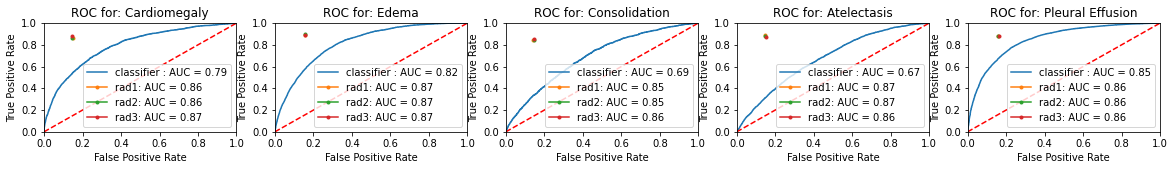

Epoch [1] [save] [03032021-172859] loss= tensor(0.4445, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


0 % batches computed
0
0.5436750054359436
0.5650624632835388
10 % batches computed
2800
0.4928036630153656
0.6045662760734558
20 % batches computed
5600
0.4620976448059082
0.5677502751350403
30 % batches computed
8400
0.5142859816551208
0.5747827887535095


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


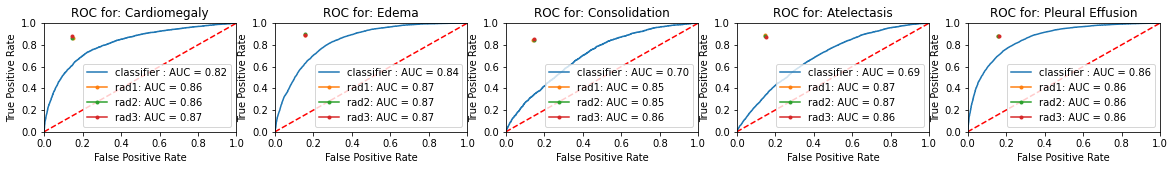

Epoch [2] [save] [03032021-180136] loss= tensor(0.4316, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


0 % batches computed
0
0.4108423590660095
0.5785731673240662
10 % batches computed
2800
0.3589222729206085
0.5544239282608032
20 % batches computed
5600
0.46177396178245544
0.5691776871681213
30 % batches computed
8400
0.46564990282058716
0.5882627367973328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


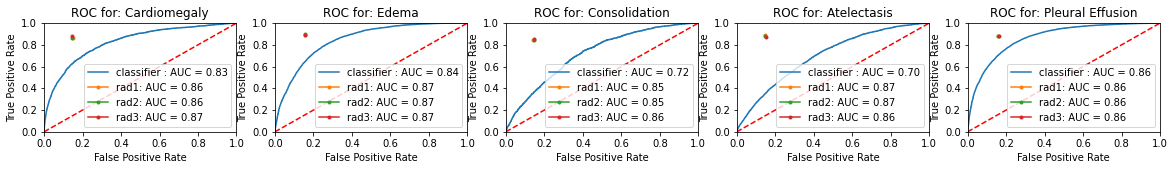

Epoch [3] [save] [03032021-183415] loss= tensor(0.4273, device='cuda:0')


In [ ]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime
batch, losst, losse = CheXpertTrainer_CE.train(model_classifier, dataLoaderTrain, dataLoaderValidTrain, nnClassCount, 3, timestampLaunch, checkpoint = None)

In [ ]:
#outGT1, outPRED1 = CheXpertTrainer.test(model_sig, dataLoaderTest, nnClassCount, "m-epoch5-13052020-174143_min.pth.tar", class_names)
def test_model(model, dataloader):
    model.eval()
    model_out = [[] for temp_con in range(14)] # model predictions
    target_all = [[] for temp_con in range(14)] # target as cpu array
    rad_1 = [[] for temp_con in range(14)] # radiologist 1 predictions
    rad_2 = [[] for temp_con in range(14)]
    rad_3 = [[] for temp_con in range(14)]
    # get predictions
    for i, (input, target, rad1, rad2, rad3, weights) in enumerate(dataloader):
        target = target.cuda()
        
        bs, c, h, w = input.size()
        varInput = input.view(-1, c, h, w)

        out = model(varInput.cuda())
        for batch in range(0,len(rad1)):
            j = 0
            for cls in range(14):
                is_uncertain = weights[batch][cls].cpu().numpy().item()
                if is_uncertain == 1:
                    out_softmax_class = torch.nn.functional.softmax(out[batch][j:j+2])
                    model_out[cls].append(out_softmax_class[1].detach().cpu().numpy().item())
                    rad_1[cls].append(rad1[batch][cls].cpu().numpy().item())
                    rad_2[cls].append(rad2[batch][cls].cpu().numpy().item())
                    rad_3[cls].append(rad3[batch][cls].cpu().numpy().item())
                    target_all[cls].append(target[batch][cls].cpu().numpy().item())
                j += 2
                    
    j = 0
    for i in range(nnClassCount):
        if i != 2 and i!= 5 and i != 6 and i != 8 and i!= 10:
            continue
        
        fpr, tpr, threshold = metrics.roc_curve(target_all[i], model_out[i])
        roc_auc = metrics.auc(fpr, tpr)
        f = plt.subplot(1, 5, j+1)
        j +=1

        plt.title('ROC for: ' + class_names[i])
        plt.plot(fpr, tpr, label = 'classifier : AUC = %0.2f' % roc_auc)

        fpr, tpr, threshold = metrics.roc_curve(target_all[i], rad_1[i])
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr[1], tpr[1],marker='o', markersize=3,  label = 'rad1: AUC = %0.2f' % roc_auc)
        fpr, tpr, threshold = metrics.roc_curve(target_all[i], rad_2[i])
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr[1], tpr[1],marker='o', markersize=3,  label = 'rad2: AUC = %0.2f' % roc_auc)
        fpr, tpr, threshold = metrics.roc_curve(target_all[i], rad_3[i])
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr[1], tpr[1],marker='o', markersize=3,  label = 'rad3: AUC = %0.2f' % roc_auc)


        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 2
    plt.rcParams["figure.figsize"] = fig_size

    plt.savefig("roc_modelrad_val.png", dpi=1000)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


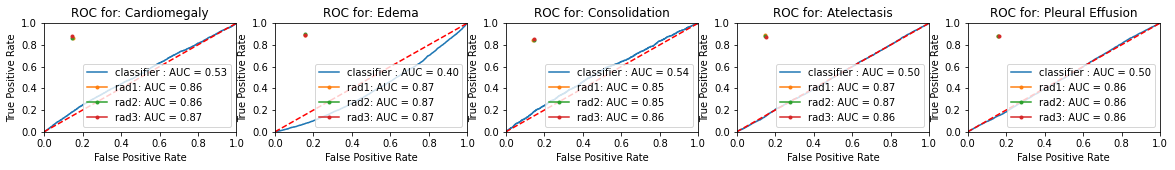

In [ ]:
test_model(model_classifier, dataLoaderValidTrain)

In [ ]:
for i, (input, target, rad1, rad2, rad3, weights) in enumerate(dataLoaderValidTrain):
    target = target.cuda()
    
    bs, c, h, w = input.size()
    varInput = input.view(-1, c, h, w)

    out = model_classifier(varInput.cuda())
    print(out)
    break

## Calibration of models

In [ ]:

class ModelWithTemperature(nn.Module):
    """
    Adapted from https://github.com/gpleiss/temperature_scaling/blob/master/temperature_scaling.py
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(14) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        batch_size = logits.size()[0]  # batch_size
        j = 0
        logits_temp = logits.clone()
        for i in range(14):
            logits_temp[range(batch_size),j:j+2] = logits_temp[range(batch_size),j:j+2].clone()/self.temperature[i]
            j += 2 # index variable update, for CE use 2, for LCE use 3
        return logits_temp

    def set_temp(self, valid_loader):
        self.cuda()
        self.model.eval()
        logits_list = []
        logits_temp_list = []
        labels_list = []
        weights_list = []
        with torch.no_grad():
            for i, (input, target, rad1, rad2, rad3, weights) in enumerate(valid_loader):
                target = target.cuda()
                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)
                out = self.model(varInput)
                out_temp = self.temperature_scale(out)
                weights_list.append(weights.cuda(non_blocking=True))
                logits_list.append(out.cuda())
                labels_list.append(target)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()
            weights = torch.cat(weights_list).cuda()
        before_temperature_nll = CrossEntropyLoss(logits, labels, weights).item()
        print('Before temperature - NLL: %.3f' % (before_temperature_nll))
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=1000)
        def eval():
            loss = CrossEntropyLoss(self.temperature_scale(logits), labels, weights)
            optimizer.zero_grad()
            loss.backward(retain_graph=True )
            return loss
        optimizer.step(eval)
        after_temperature_nll = CrossEntropyLoss(self.temperature_scale(logits), labels, weights).item()
        print('After temperature - NLL: %.3f' % (after_temperature_nll))
        print(f'temperatures are {self.temperature}')


In [ ]:
model_class_calib = ModelWithTemperature(model_classifier)
model_class_calib.set_temp(dataLoaderValidTrain)

# Teaching


# Coverage Evaluation with error bars

## learn models

In [ ]:
train_size = 0.999 # limit size: 0-1

In [ ]:
dataset_all_names = get_patient_names(pathFileTrain) # returns a dict
patients_train, patients_test = train_test_split(list(dataset_all_names.keys()) ,test_size=0.1, random_state=66) # test size is 10%
patients_train, patients_val = train_test_split(patients_train, test_size=0.1111, random_state=66) #val size 10%
patients_train_leftout, patients_train = train_test_split(patients_train, test_size=train_size) # change random_state

patients_train = {patient:1 for  patient in patients_train}
patients_val = {patient:1 for patient in patients_val}
patients_test = {patient:1 for patient in patients_test}
dataset_train = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_train, transform = transform_train)
dataset_val = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_val, transform = transform_test)
dataset_test = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_test, transform = transform_test)
dataLoaderTrain = DataLoader(dataset=dataset_train, batch_size=trBatchSize, shuffle=True,  num_workers=16, pin_memory=True)
dataLoaderValidTrain = DataLoader(dataset=dataset_val, batch_size=trBatchSize, shuffle=True,  num_workers=16, pin_memory=True)
dataLoaderTestTrain = DataLoader(dataset=dataset_test,  batch_size=trBatchSize,  shuffle=False,  num_workers=16, pin_memory=True)
dataset_all_names_val = get_patient_names(pathFileValid) # returns a dict
datasetValid = CheXpertDataSet_rad(pathFileValid, exp_fake, dataset_all_names_val , transform =  transform_test)            
dataLoaderTest = DataLoader(dataset=datasetValid, num_workers=24, pin_memory=True)


In [ ]:
print("Number of data points:")
print(f' train: {len(dataset_train)}, test {len(dataset_test)}, val {len(dataset_val)}')

Number of data points:
 train: 178311, test 22623, val 22323


Ours: defer, first learn without defer, then learn to defer

learn classifier

In [ ]:
# initialize and load the model
model_classifier = DenseNet121_CE(nnClassCount).cuda()
model_classifier = torch.nn.DataParallel(model_classifier).cuda()

timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime
batch, losst, losse = CheXpertTrainer_CE.train(model_classifier, dataLoaderTrain, dataLoaderValidTrain, nnClassCount, 4, timestampLaunch, checkpoint =  None)

In [ ]:
model_classifier = DenseNet121_CE(nnClassCount).cuda()
model_classifier = torch.nn.DataParallel(model_classifier).cuda()
modelCheckpoint = torch.load("/content/chexpert/classifier_ce_u_epoch5.pth.tar")
model_classifier.load_state_dict(modelCheckpoint['state_dict'])

<All keys matched successfully>

In [ ]:

timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime
batch, losst, losse = CheXpertTrainer_CE.train(model_classifier, dataLoaderTrain, dataLoaderValidTrain, nnClassCount, 1, timestampLaunch, checkpoint =  None)

learn radiologist model

calibrate models

In [ ]:
model_class_calib = ModelWithTemperature(model_classifier)
model_class_calib.set_temp(dataLoaderValidTrain)


## get predictions

In [ ]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng


In [ ]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Get predictions first 

In [ ]:
model_class_calib.eval()
# now only for rad_1
conf_class = [[] for temp_con in range(14)] # model predictions
conf_out = [[] for temp_con in range(14)] 
target_all = [[] for temp_con in range(14)] # target as cpu array
rad_1 = [[] for temp_con in range(14)] # radiologist 1 predictions
rad_2 = [[] for temp_con in range(14)]
rad_3 = [[] for temp_con in range(14)]
rad_ = [[] for temp_con in range(14)]

print("getting predictions")
for i, (input, target, rad1, rad2, rad3, weights) in enumerate(dataLoaderTestTrain):
    
    target = target.cuda()
    bs, c, h, w = input.size()
    varInput = input.view(-1, c, h, w)

    out = model_class_calib(varInput)
    for batch in range(0,len(rad1)):
        j = 0
        for cls in range(14):
            is_uncertain = weights[batch][cls].cpu().numpy().item()
            if is_uncertain == 1:
                out_softmax_class = torch.nn.functional.softmax(out[batch][j:j+2])
                conf_out[cls].append(1 - max(out_softmax_class[0].detach().cpu().numpy().item(),out_softmax_class[1].detach().cpu().numpy().item()))
                conf_class[cls].append(out_softmax_class[1].detach().cpu().numpy().item())
                rad_1[cls].append(rad1[batch][cls].cpu().numpy().item())
                rad_2[cls].append(rad2[batch][cls].cpu().numpy().item())
                rad_3[cls].append(rad3[batch][cls].cpu().numpy().item())
                if rad_index == 1:
                    rad_[cls].append(rad1[batch][cls].cpu().numpy().item())
                elif rad_index == 2:
                    rad_[cls].append(rad2[batch][cls].cpu().numpy().item())
                elif rad_index == 3:
                    rad_[cls].append(rad3[batch][cls].cpu().numpy().item())
                target_all[cls].append(target[batch][cls].cpu().numpy().item())
            j += 2


getting predictions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


predictions above dont change, only rad behavior

In [ ]:
aucs_conf_list = []
aps_conf_list = []
coverage_list = []
max_trials = 5
for trial in range(max_trials):
    print(f'ON TRIAL {trial+1} ')
    #get new dataset
    dataset_all_names = get_patient_names(pathFileTrain) # returns a dict
    patients_train, patients_test = train_test_split(list(dataset_all_names.keys()) ,test_size=0.1, random_state=66) # test size is 10%
    patients_train, patients_val = train_test_split(patients_train, test_size=0.1111, random_state=66) #val size 10%
    patients_train_leftout, patients_train = train_test_split(patients_train, test_size=train_size) # change random_state
    patients_train = {patient:1 for  patient in patients_train}
    patients_val = {patient:1 for patient in patients_val}
    patients_test = {patient:1 for patient in patients_test}
    dataset_train = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_train, transform = transform_train)
    dataset_val = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_val, transform = transform_test)
    dataset_test = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_test, transform = transform_test)
    dataLoaderTrain = DataLoader(dataset=dataset_train, batch_size=trBatchSize, shuffle=True,  num_workers=16, pin_memory=True)
    dataLoaderValidTrain = DataLoader(dataset=dataset_val, batch_size=trBatchSize, shuffle=True,  num_workers=16, pin_memory=True)
    dataLoaderTestTrain = DataLoader(dataset=dataset_test,  batch_size=trBatchSize,  shuffle=False,  num_workers=16, pin_memory=True)
    dataset_all_names_val = get_patient_names(pathFileValid) # returns a dict
    datasetValid = CheXpertDataSet_rad(pathFileValid, exp_fake, dataset_all_names_val , transform =  transform_test)            
    dataLoaderTest = DataLoader(dataset=datasetValid, num_workers=24, pin_memory=True)

    # get rad_1 predictions new
    target_all = [[] for temp_con in range(14)] # target as cpu array
    rad_1 = [[] for temp_con in range(14)] # radiologist 1 predictions
    rad_2 = [[] for temp_con in range(14)]
    rad_3 = [[] for temp_con in range(14)]
    rad_ = [[] for temp_con in range(14)]
    for i, (input, target, rad1, rad2, rad3, weights) in enumerate(dataLoaderTestTrain):
        for batch in range(0,len(rad1)):
            j = 0
            for cls in range(14):
                is_uncertain = weights[batch][cls].cpu().numpy().item()
                if is_uncertain == 1:
                    rad_1[cls].append(rad1[batch][cls].cpu().numpy().item())
                    rad_2[cls].append(rad2[batch][cls].cpu().numpy().item())
                    rad_3[cls].append(rad3[batch][cls].cpu().numpy().item())
                    if rad_index == 1:
                        rad_[cls].append(rad1[batch][cls].cpu().numpy().item())
                    elif rad_index == 2:
                        rad_[cls].append(rad2[batch][cls].cpu().numpy().item())
                    elif rad_index == 3:
                        rad_[cls].append(rad3[batch][cls].cpu().numpy().item())
                    target_all[cls].append(target[batch][cls].cpu().numpy().item())

    coverage_list = covs
    aucs_conf = [[0]*101 for _ in range(14)]
    aps_conf = [[0]*101 for _ in range(14)]
    print("Getting tresholds for ModelConfidence")
    for cls in range(14):
        print(f'class {class_names[cls]}')
        conf_sorted = sorted(conf_out[cls])
        for cov in range(0,101):
            preds = []
            coverage = 0
            total = len(conf_out[cls]) -1
            tau = conf_sorted[int(total * cov/100)]
            for j in range(len(conf_out[cls])):
                if  conf_out[cls][j] > tau:
                    preds.append(rad_[cls][j])
                else:
                    preds.append(conf_class[cls][j])
                    coverage += 1
            coverage_tau = coverage / total *100
            aucs_conf[cls][cov] = roc_auc_score(target_all[cls], preds)
            aps_conf[cls][cov] = metrics.average_precision_score(target_all[cls], preds)
    aucs_conf_list.append(aucs_conf)
    aps_conf_list.append(aps_conf)


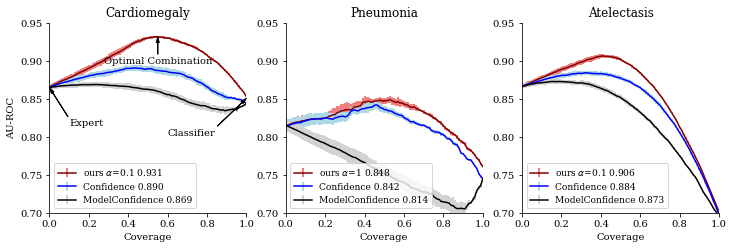

In [ ]:

import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

j = 0
for k in range(14):
    
    if k not in [2,8,7]:
        continue
    f = plt.subplot(1, 3, j+1)
    j += 1
    plt.title(class_names[k])
    #plt.plot(covs[k], aucs[k],label = f'ours alpha={alpha[k]}: max AUC {max(aucs[k]):.3f}')
    plt.errorbar(covs[k], [np.average([aucs_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))] , yerr=[np.std([aucs_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))], label=f'ours $\\alpha$={alpha[k]} {max([np.average([aucs_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]):.3f}',color='maroon',ecolor='lightcoral', elinewidth=2, capsize=0)
    plt.errorbar(covs[k], [np.average([aucs_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))] , yerr=[np.std([aucs_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))], label=f'Confidence {max([np.average([aucs_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]):.3f}',color='blue',ecolor='lightblue', elinewidth=2, capsize=0)
    plt.errorbar(covs[k], [np.average([aucs_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))] , yerr=[np.std([aucs_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))], label=f'ModelConfidence {max([np.average([aucs_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]):.3f}',color='black',ecolor='lightgray', elinewidth=2, capsize=0)
    #plt.plot(covs_confidence[k], aucs_confidence[k], label =' Confidence: max AUC %0.3f' % max(aucs_confidence[k]))

    plt.legend(loc = 'lower left',fontsize=9)
    plt.xlim([0, 1])
    plt.ylim([0.7, 0.95])
    #plt.plot([0.5, 0.5], [0, 1],'r--')
    if j == 1:
        #plt.text(covs[0][0] +0.03,aucs[k][0] - 0.005,'Expert', horizontalalignment='left', verticalalignment='top', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 1})
        #plt.plot(covs[0][0] ,aucs[k][0], marker='o', markersize=3)
        plt.annotate('Expert', xy=(covs[0][0], aucs[k][0]), xytext=(covs[0][0] +0.1, aucs[k][0] -0.05),arrowprops=dict(facecolor='black', width=0.2,headwidth=3,headlength=6))
        #plt.plot(covs[0][0] ,aucs[k][0], marker='o', markersize=7)
        plt.annotate('Classifier', xy=(covs[0][-1], aucs[k][-1]-0.002), xytext=(covs[0][-1] -0.4, aucs[k][-1] -0.05),arrowprops=dict(facecolor='black', width=0.2,headwidth=3,headlength=6))
        plt.annotate('Optimal Combination',ha='center', xy=(covs[0][55], aucs[k][55]), xytext=(covs[0][55] , aucs[k][55] -0.035),arrowprops=dict(facecolor='black', width=0.2,headwidth=3,headlength=6))
        plt.ylabel('AU-ROC')
    #else:
     #   plt.yticks(ticks= [0.7,0.75,0.8,0.85],labels=[])
    f.spines['right'].set_visible(False)
    f.spines['top'].set_visible(False)
    plt.xlabel('Coverage')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 3.5
plt.rcParams["figure.figsize"] = fig_size
plt.savefig("auc_vs_cov_toyexpert7-1-0.75.pdf",dpi=1000)
plt.show()

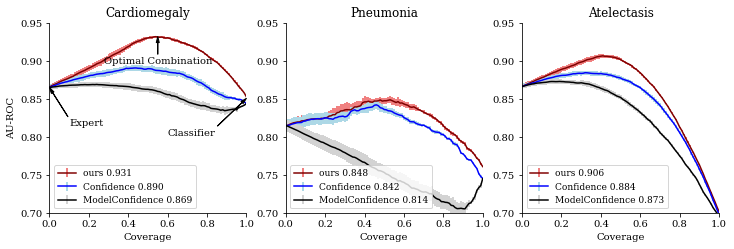

In [ ]:

import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

j = 0
for k in range(14):
    
    if k not in [2,8,7]:
        continue
    f = plt.subplot(1, 3, j+1)
    j += 1
    plt.title(class_names[k])
    #plt.plot(covs[k], aucs[k],label = f'ours alpha={alpha[k]}: max AUC {max(aucs[k]):.3f}')
    plt.errorbar(covs[k], [np.average([aucs_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))] , yerr=[np.std([aucs_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))], label=f'ours {max([np.average([aucs_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]):.3f}',color='maroon',ecolor='lightcoral', elinewidth=2, capsize=0)
    plt.errorbar(covs[k], [np.average([aucs_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))] , yerr=[np.std([aucs_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))], label=f'Confidence {max([np.average([aucs_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]):.3f}',color='blue',ecolor='lightblue', elinewidth=2, capsize=0)
    plt.errorbar(covs[k], [np.average([aucs_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))] , yerr=[np.std([aucs_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))], label=f'ModelConfidence {max([np.average([aucs_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]):.3f}',color='black',ecolor='lightgray', elinewidth=2, capsize=0)
    #plt.plot(covs_confidence[k], aucs_confidence[k], label =' Confidence: max AUC %0.3f' % max(aucs_confidence[k]))

    plt.legend(loc = 'lower left',fontsize=9)
    plt.xlim([0, 1])
    plt.ylim([0.7, 0.95])
    #plt.plot([0.5, 0.5], [0, 1],'r--')
    if j == 1:
        #plt.text(covs[0][0] +0.03,aucs[k][0] - 0.005,'Expert', horizontalalignment='left', verticalalignment='top', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 1})
        #plt.plot(covs[0][0] ,aucs[k][0], marker='o', markersize=3)
        plt.annotate('Expert', xy=(covs[0][0], aucs[k][0]), xytext=(covs[0][0] +0.1, aucs[k][0] -0.05),arrowprops=dict(facecolor='black', width=0.2,headwidth=3,headlength=6))
        #plt.plot(covs[0][0] ,aucs[k][0], marker='o', markersize=7)
        plt.annotate('Classifier', xy=(covs[0][-1], aucs[k][-1]-0.002), xytext=(covs[0][-1] -0.4, aucs[k][-1] -0.05),arrowprops=dict(facecolor='black', width=0.2,headwidth=3,headlength=6))
        plt.annotate('Optimal Combination',ha='center', xy=(covs[0][55], aucs[k][55]), xytext=(covs[0][55] , aucs[k][55] -0.035),arrowprops=dict(facecolor='black', width=0.2,headwidth=3,headlength=6))
        plt.ylabel('AU-ROC')
    #else:
     #   plt.yticks(ticks= [0.7,0.75,0.8,0.85],labels=[])
    f.spines['right'].set_visible(False)
    f.spines['top'].set_visible(False)
    plt.xlabel('Coverage')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 3.5
plt.rcParams["figure.figsize"] = fig_size
plt.savefig("auc_vs_cov_toyexpert_3.pdf",dpi=1000)
plt.show()

In [ ]:

import matplotlib.pyplot as plt
j = 0
for k in range(14):
    if k != 2 and k!= 5 and k != 6 and k != 8 and k!= 10:
        continue
    f = plt.subplot(1, 5, j+1)
    j += 1
    plt.title(class_names[k])
    plt.errorbar(covs[k], [np.average([aps_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))] , yerr=[np.std([aps_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))], label=f'ours $\\alpha$={alpha[k]} {max([np.average([aps_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]):.3f}',color='maroon',ecolor='lightcoral', elinewidth=2, capsize=0)
    plt.errorbar(covs[k], [np.average([aps_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))] , yerr=[np.std([aps_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))], label=f'Confidence {max([np.average([aps_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]):.3f}',color='blue',ecolor='lightblue', elinewidth=2, capsize=0)
    plt.errorbar(covs[k], [np.average([aps_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))] , yerr=[np.std([aps_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))], label=f'ModelConfidence {max([np.average([aps_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]):.3f}',color='black',ecolor='lightgray', elinewidth=2, capsize=0)

    plt.legend(fontsize=9,loc='best')
    plt.xlim([0, 1])
    #plt.ylim([0.2, 0.92])
    #plt.plot([0.5, 0.5], [0, 1],'r--')
    f.spines['right'].set_visible(False)
    f.spines['top'].set_visible(False)
    if j == 1:
        plt.ylim([0.4, 0.8])
        #plt.annotate('Expert', xy=(covs[0][0], aps[k][0]), xytext=(covs[0][0] +0.1, aps[k][0] -0.05),arrowprops=dict(facecolor='black', width=0.2,headwidth=3,headlength=6))
        #plt.annotate('Classifier', xy=(covs[0][-1], aps[k][-1]), xytext=(covs[0][-1] -0.4, aps[k][-1] -0.05),arrowprops=dict(facecolor='black', width=0.2,headwidth=3,headlength=6))
        plt.ylabel('AU-PR')
    elif j ==2:
        plt.ylim([0.5, 0.9])
    elif j == 3:
        plt.ylim([0.2, 0.6])

    elif j == 4:
        plt.ylim([0.3, 0.7])
    elif j == 5:
        plt.ylim([0.6, 1.0])
        #plt.yticks(ticks= [0.20,0.3,0.4,0.5,0.6,0.7,0.8,0.9],labels=[])
    plt.ylim([0.1, 0.92])
    plt.xlabel('Coverage')
plt.savefig("ap_vs_cov_toyexpert7-1-0.75.pdf",dpi=1000) #_trainsize-"+str(train_size)+"
plt.show()

In [ ]:
for k in range(14):
    #if k != 2 and k!= 5 and k != 6 and k != 8 and k!= 10:
    #    continue
    print("#############################")
    print(f'on task {class_names[k]}')
    defer = [max([aucs_defer_list[triall][k][i] for i in range(len(aucs[k]))]) for triall in range(max_trials)]
    conf = [max([aucs_conf_list[triall][k][i] for i in range(len(aucs[k]))]) for triall in range(max_trials)]
    confidence = [max([aucs_confidence_list[triall][k][i] for i in range(len(aucs[k]))]) for triall in range(max_trials)]
    defer = np.asarray(defer)
    conf = np.asarray(conf)
    confidence = np.asarray(confidence)
    print(f'max AUC defer {np.average(defer)}$\\pm${np.std(defer):.3f}')
    print(f'max AUC defer {np.average(conf)}$\\pm${np.std(conf):.3f}')
    print(f'max AUC defer {np.average(confidence)}$\\pm${np.std(confidence):.3f}')

    print(f'AUC max difference between Defer and ModelConfidence is {np.average(defer-conf):.3f}$\\pm${np.std(defer-conf):.3f}')
    print(f'AUC max difference between Defer and Confidence is {np.average(defer-confidence):.3f}$\\pm${np.std(defer-confidence):.3f}')